In [0]:
4#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Importing models for machine learning
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import  KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [0]:
#Importing the dataframe
final_df = pd.read_csv('final_analysis_frame.csv')
final_df.drop(columns = 'Unnamed: 0', inplace = True)
final_df.head()

,itunes_app_id,rating_list,top_rank,top_rank_days,growth,app_name,developer,website,category,is_editor_choice,rating_oo5,num_ratings,has_iap,release_date,current_version,age_rating,file_size,editor_notes,description,os_compatibility,languages,price,itunes_link,date,subscription_service
0,1000008721,Lifestyle - topgrossingapplications,166.0,1,0.0,DYC TongShu,Darren Gibbs,http://darrengibbs.info/TongShu,Lifestyle,False,5.0,6.0,False,09/07/2016,NaN,Rated 4+,10.1 MB,NaN,\nDescription\n\n\nThe Chinese “tong shu” or a...,Requires iOS 8.0 or later. Compatible with iPh...,English,$9.99,https://itunes.apple.com/app/id1000008721,2019-06-11-1512,0
1,1000008721,Lifestyle - toppaidapplications,83.0,1,41.0,DYC TongShu,Darren Gibbs,http://darrengibbs.info/TongShu,Lifestyle,False,5.0,6.0,False,09/07/2016,NaN,Rated 4+,10.1 MB,NaN,\nDescription\n\n\nThe Chinese “tong shu” or a...,Requires iOS 8.0 or later. Compatible with iPh...,English,$9.99,https://itunes.apple.com/app/id1000008721,2019-06-11-1512,0
2,1000017994,Health-and-fitness - topfreeapplications,16.0,1,72.0,Cardiogram for Apple Watch,"Cardiogram, Inc.",https://cardiogr.am,Health & Fitness,False,4.2,2700.0,True,"Jun 3, 2019",2.12.0,Rated 12+ for the following:,80.6 MB,NaN,\nDescription\n\n\nYour Apple Watch measures y...,Requires iOS 9.3 or later. Compatible with iPh...,English,Free,https://itunes.apple.com/app/id1000017994,2019-06-11-1512,1
3,1000017994,Health-and-fitness - topgrossingapplications,155.0,1,14.0,Cardiogram for Apple Watch,"Cardiogram, Inc.",https://cardiogr.am,Health & Fitness,False,4.2,2700.0,True,"Jun 3, 2019",2.12.0,Rated 12+ for the following:,80.6 MB,NaN,\nDescription\n\n\nYour Apple Watch measures y...,Requires iOS 9.3 or later. Compatible with iPh...,English,Free,https://itunes.apple.com/app/id1000017994,2019-06-11-1512,1
4,1000077500,Medical - topgrossingapplications,71.0,1,30.0,ACLS Advisor 2017 Guidelines,Paul Chan,https://www.facebook.com/pages/Current-Clinica...,Medical,False,1.2,9.0,True,"Mar 13, 2017",2017.1,Rated 12+ for the following:,10.3 MB,NaN,\nDescription\n\n\nACLS Advisor features the N...,Requires iOS 6.0 or later. Compatible with iPh...,English,Free,https://itunes.apple.com/app/id1000077500,2019-06-11-1512,0


# Exploratory Data Analysis

In [0]:
#Checking for columns with missing values
final_df.isnull().sum()

itunes_app_id                0
rating_list                  0
top_rank                     0
top_rank_days                0
growth                       0
app_name                     1
developer                    0
website                    231
category                     0
is_editor_choice             0
rating_oo5               12587
num_ratings              12587
has_iap                      0
release_date              3797
current_version           7305
age_rating                   0
file_size                    0
editor_notes            100733
description                  0
os_compatibility             0
languages                    0
price                        0
itunes_link                  0
date                         0
subscription_service         0
dtype: int64

In [0]:
#Drop less important columns and column with high missing values
final_df.drop(columns = ['current_version', 'date', 'os_compatibility', 'editor_notes'], inplace = True)

In [0]:
#Since we are going to drop duplicates, it makes sense to replace top rank, top_rank_days, growth
ranking_df = final_df.groupby('itunes_app_id', as_index = False).agg({'top_rank': 'min', 'top_rank_days': 'max', 'growth':'max'})
ranking_df.head()

,itunes_app_id,top_rank,top_rank_days,growth
0,281796108,4.0,2,51.0
1,281935788,1.0,640,639.0
2,281940292,2.0,52,48.0
3,281941097,4.0,124,120.0
4,282614216,39.0,4,62.0


In [0]:
#Merging the aggregated rankings
final_df = pd.merge(final_df,ranking_df, on = 'itunes_app_id')
final_df.drop(columns = ['top_rank_x', 'top_rank_days_x', 'growth_x', 'rating_list'], inplace = True)
final_df.head()

,itunes_app_id,app_name,developer,website,category,is_editor_choice,rating_oo5,num_ratings,has_iap,release_date,age_rating,file_size,description,languages,price,itunes_link,subscription_service,top_rank_y,top_rank_days_y,growth_y
0,1000008721,DYC TongShu,Darren Gibbs,http://darrengibbs.info/TongShu,Lifestyle,False,5.0,6.0,False,09/07/2016,Rated 4+,10.1 MB,\nDescription\n\n\nThe Chinese “tong shu” or a...,English,$9.99,https://itunes.apple.com/app/id1000008721,0,83.0,1,41.0
1,1000008721,DYC TongShu,Darren Gibbs,http://darrengibbs.info/TongShu,Lifestyle,False,5.0,6.0,False,09/07/2016,Rated 4+,10.1 MB,\nDescription\n\n\nThe Chinese “tong shu” or a...,English,$9.99,https://itunes.apple.com/app/id1000008721,0,83.0,1,41.0
2,1000017994,Cardiogram for Apple Watch,"Cardiogram, Inc.",https://cardiogr.am,Health & Fitness,False,4.2,2700.0,True,"Jun 3, 2019",Rated 12+ for the following:,80.6 MB,\nDescription\n\n\nYour Apple Watch measures y...,English,Free,https://itunes.apple.com/app/id1000017994,1,16.0,1,72.0
3,1000017994,Cardiogram for Apple Watch,"Cardiogram, Inc.",https://cardiogr.am,Health & Fitness,False,4.2,2700.0,True,"Jun 3, 2019",Rated 12+ for the following:,80.6 MB,\nDescription\n\n\nYour Apple Watch measures y...,English,Free,https://itunes.apple.com/app/id1000017994,1,16.0,1,72.0
4,1000077500,ACLS Advisor 2017 Guidelines,Paul Chan,https://www.facebook.com/pages/Current-Clinica...,Medical,False,1.2,9.0,True,"Mar 13, 2017",Rated 12+ for the following:,10.3 MB,\nDescription\n\n\nACLS Advisor features the N...,English,Free,https://itunes.apple.com/app/id1000077500,0,71.0,1,30.0


In [0]:
#Duplicate removal
final_df.drop_duplicates(subset = 'itunes_app_id', keep = 'first', inplace = True)

In [0]:
#interesting find
final_df[final_df['app_name'].isnull()]
#The name of the app was NA (:D)

,itunes_app_id,app_name,developer,website,category,is_editor_choice,rating_oo5,num_ratings,has_iap,release_date,age_rating,file_size,description,languages,price,itunes_link,subscription_service,top_rank_y,top_rank_days_y,growth_y
63375,449134868,NaN,Promedia,http://na.se/app,News,False,NaN,NaN,True,"May 30, 2019",Rated 4+,16.7 MB,\nDescription\n\n\nNu tar vi lokala nyheter än...,English,Free,https://itunes.apple.com/app/id449134868,0,109.0,1,27.0


In [0]:
#Imputing null values for features in rating_oo5 and num_ratings features
#Creating a slice from the original dataframe
df1 = final_df[['category', 'rating_oo5', 'num_ratings']]
ratings_cat_group = df1.groupby('category').mean()

In [0]:
#Filling null values with the average in the application category
rating_null_fill = final_df[(final_df['rating_oo5'].isnull()) & (final_df['num_ratings'].isnull())][['itunes_app_id','category', 'rating_oo5', 'num_ratings']]
rating_null_fill['rating_oo5'] = rating_null_fill['category'].apply(lambda a: np.round(ratings_cat_group.loc[a]['rating_oo5'],2))
rating_null_fill['num_ratings'] = rating_null_fill['category'].apply(lambda a: np.round(ratings_cat_group.loc[a]['num_ratings'],0))
rating_null_fill.drop(columns = 'category', inplace = True)

#Remerging into the final dataframe
final_df = pd.merge(final_df, rating_null_fill, how = 'left', on = 'itunes_app_id')
final_df['rating_oo5_x'].fillna(final_df['rating_oo5_y'], inplace = True)
final_df['num_ratings_x'].fillna(final_df['num_ratings_y'], inplace = True)
final_df.drop(columns = ['rating_oo5_y', 'num_ratings_y'], inplace = True)
final_df.head()

,itunes_app_id,app_name,developer,website,category,is_editor_choice,rating_oo5_x,num_ratings_x,has_iap,release_date,age_rating,file_size,description,languages,price,itunes_link,subscription_service,top_rank_y,top_rank_days_y,growth_y
0,1000008721,DYC TongShu,Darren Gibbs,http://darrengibbs.info/TongShu,Lifestyle,False,5.0,6.0,False,09/07/2016,Rated 4+,10.1 MB,\nDescription\n\n\nThe Chinese “tong shu” or a...,English,$9.99,https://itunes.apple.com/app/id1000008721,0,83.0,1,41.0
1,1000017994,Cardiogram for Apple Watch,"Cardiogram, Inc.",https://cardiogr.am,Health & Fitness,False,4.2,2700.0,True,"Jun 3, 2019",Rated 12+ for the following:,80.6 MB,\nDescription\n\n\nYour Apple Watch measures y...,English,Free,https://itunes.apple.com/app/id1000017994,1,16.0,1,72.0
2,1000077500,ACLS Advisor 2017 Guidelines,Paul Chan,https://www.facebook.com/pages/Current-Clinica...,Medical,False,1.2,9.0,True,"Mar 13, 2017",Rated 12+ for the following:,10.3 MB,\nDescription\n\n\nACLS Advisor features the N...,English,Free,https://itunes.apple.com/app/id1000077500,0,71.0,1,30.0
3,1000103741,Mini Taiko,Jason Lew,http://minitaiko.com,Music,False,5.0,4.0,True,"Aug 6, 2015",Rated 4+,31 MB,\nDescription\n\n\nMini Taiko puts the awesome...,"English, Japanese",$1.99,https://itunes.apple.com/app/id1000103741,0,79.0,1,37.0
4,1000129248,Life Budget - Personal Finance & Money Management,Farzad Farhoosh,http://lifebudgetapp.com,Finance,False,4.3,58.0,True,"Jan 13, 2016",Rated 4+,54.2 MB,\nDescription\n\n\nLife Budget - Personal Fina...,"English, Dutch, French, German, Russian, Simpl...",Free,https://itunes.apple.com/app/id1000129248,0,71.0,1,72.0


In [0]:
#Handling missing values for website and app name

#app_name
final_df['app_name'].fillna('name: NA', inplace = True)

#website
final_df['website'].fillna('Not Available', inplace = True)

In [0]:
#Converting the release date to the date time format
final_df["release_date"]= pd.to_datetime(final_df["release_date"])

In [0]:
#Changing file size to a numerical column
final_df['file_size'] = final_df['file_size'].apply(lambda a: float(a[:-3]))

In [0]:
#Changing the languages column into lists of supported languages
final_df['languages'] = final_df['languages'].apply(lambda a: a.split(','))
#Creating a new column as number of languages supported
final_df['n_languages'] = final_df['languages'].apply(lambda a: len(a))

In [0]:
#Data cleaning for price column
final_df['price'] = final_df['price'].apply(lambda a: 0 if 'Free' in str(a) else a)
final_df['price'] = final_df['price'].apply(lambda a: a.replace('$', '') if '$' in str(a) else a)
final_df['price'] = final_df['price'].apply(lambda a: float(a))

In [0]:
#Cleaning the age_rating tab
final_df['age_rating'] = final_df['age_rating'].apply(lambda a: '4+' if '4' in str(a) else a)
final_df['age_rating'] = final_df['age_rating'].apply(lambda a: '12+' if '12' in str(a) else a)
final_df['age_rating'] = final_df['age_rating'].apply(lambda a: '17+' if '17' in str(a) else a)
final_df['age_rating'] = final_df['age_rating'].apply(lambda a: '9+' if '9' in str(a) else a)

In [0]:
#Creating a column for active days after release
final_df['curr_date'] = np.nan
final_df['curr_date'].fillna('2019-06-11', inplace = True)
final_df['release_date'].fillna('2019-06-11', inplace = True)
final_df['curr_date'] = pd.to_datetime(final_df['curr_date'])
final_df['release_date'] = pd.to_datetime(final_df['release_date'])


In [0]:
#Renaming growth columns for clarity
final_df.rename(columns={"top_rank_y": "top_rank", "top_rank_days_y": "top_rank_days", "growth_y":"rank_growth"}, inplace= True)

In [0]:
#Renaming rating columns for clarity
final_df.rename(columns={"rating_oo5_x": "rating_oo5", "num_ratings_x": "num_ratings"}, inplace= True)

# Feature Engineering from the ranking panel

In [0]:
#Creating a column for active days of the app
final_df['active_days'] = (final_df['curr_date'] - final_df['release_date']).dt.days

#Calculating Daily Growth
final_df['avg_daily_growth'] = np.nan
daily_growth = []
for i,j in enumerate(final_df['active_days']):
  grth = final_df.loc[i]['rank_growth']
  if 0 < j < 1095: 
    daily_growth.append(grth/j)
  else:
    daily_growth.append(grth/1095)
final_df['avg_daily_growth'] = daily_growth
final_df['avg_daily_growth'].fillna(0, inplace = True)

#Max growth rate column
final_df['max_growth_rate'] = (final_df['rank_growth']/(final_df['top_rank'] + final_df['rank_growth'])) * 100

# Different Visualisations

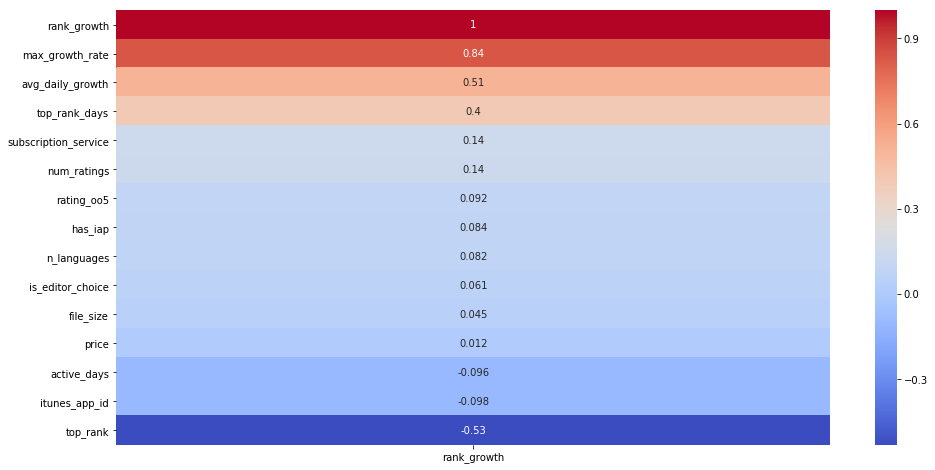

In [0]:
#Features that are highly correlated to rank growth
plt.figure(figsize = (16,8))
focus = final_df.corr()[['rank_growth']].sort_values(by = 'rank_growth', ascending = False)
sns.heatmap(focus, cmap ='coolwarm', annot = True);

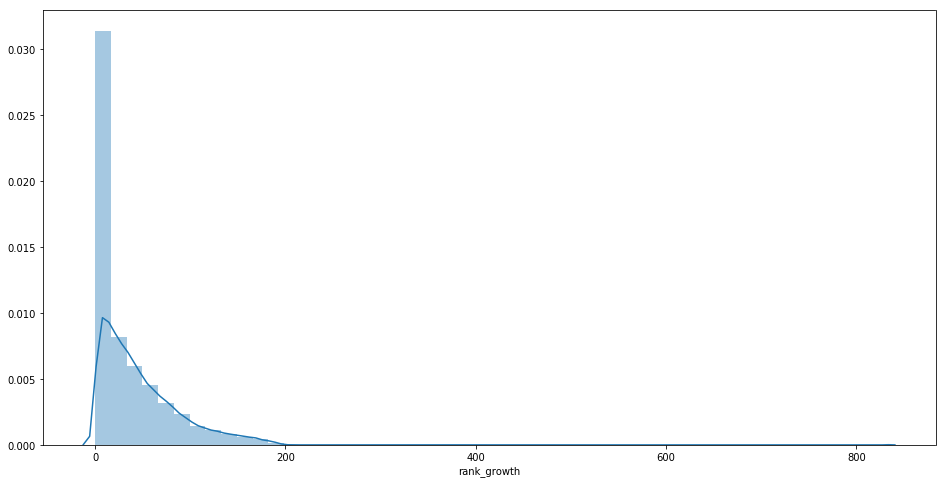

In [0]:
#Distribution of rank growth
plt.figure(figsize = (16,8))
sns.distplot(final_df['rank_growth']);

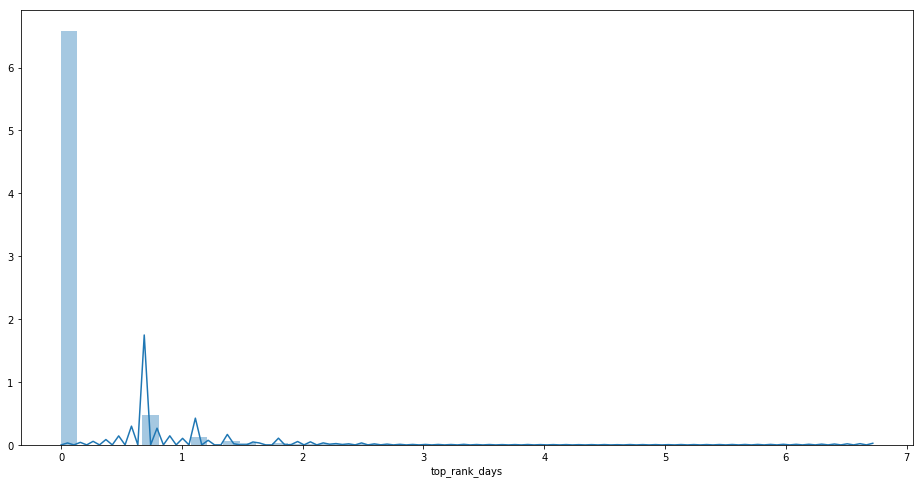

In [0]:
#Distribution of top rank days
plt.figure(figsize = (16,8))
sns.distplot(np.log(final_df['top_rank_days']));

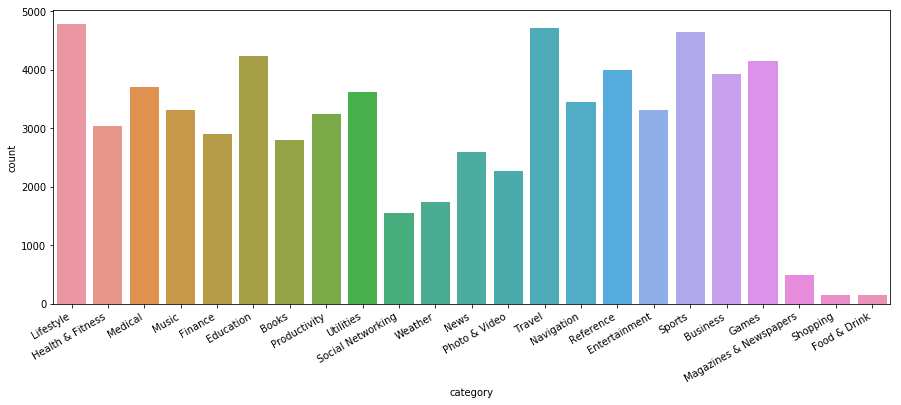

In [0]:
#Number of categories of apps in the store
x = final_df.category
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
fig.autofmt_xdate()
no_of_cat_plot = sns.categorical.countplot(x)
plt.show()

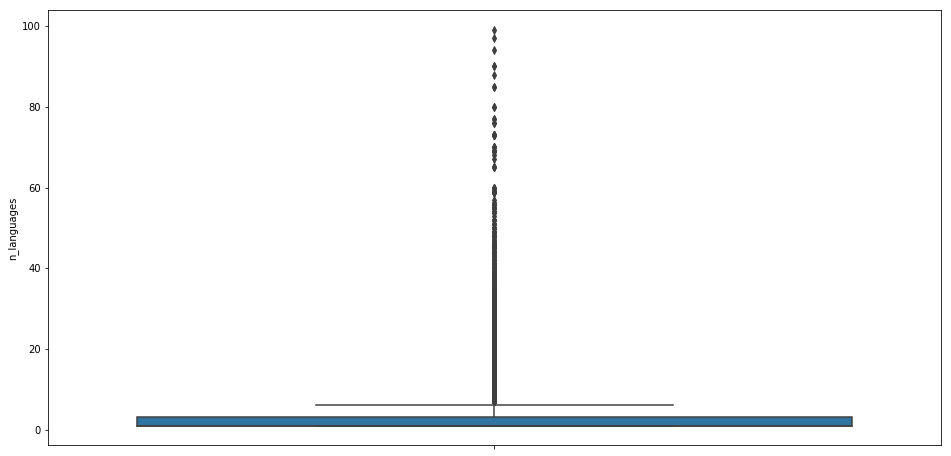

In [0]:
#Box plot to check the number of languages supported
plt.figure(figsize = (16,8))
sns.boxplot(y = final_df['n_languages'])

# Machine Learning Models Application

## Supervised Learning models

In [0]:
#Creating dummy variables for categorical columns
dummy = pd.get_dummies(final_df[['category', 'age_rating']], drop_first = False)
#Dropping categorical columns after dummy creation and merging into a final dataframe
final_df.drop(['category', 'age_rating'],1,inplace = True)
final_df = pd.concat([final_df, dummy], 1)

In [0]:
final_df.columns

Index(['itunes_app_id', 'app_name', 'developer', 'website', 'is_editor_choice',
       'rating_oo5', 'num_ratings', 'has_iap', 'release_date', 'file_size',
       'description', 'languages', 'price', 'itunes_link',
       'subscription_service', 'top_rank', 'top_rank_days', 'rank_growth',
       'n_languages', 'curr_date', 'active_days', 'avg_daily_growth',
       'max_growth_rate', 'category_Books', 'category_Business',
       'category_Education', 'category_Entertainment', 'category_Finance',
       'category_Food & Drink', 'category_Games', 'category_Health & Fitness',
       'category_Lifestyle', 'category_Magazines & Newspapers',
       'category_Medical', 'category_Music', 'category_Navigation',
       'category_News', 'category_Photo & Video', 'category_Productivity',
       'category_Reference', 'category_Shopping', 'category_Social Networking',
       'category_Sports', 'category_Travel', 'category_Utilities',
       'category_Weather', 'age_rating_12+', 'age_rating_17+', 'age

In [0]:
feat = ['is_editor_choice','rating_oo5', 'num_ratings', 'has_iap', 'file_size',
        'price','subscription_service', 'top_rank', 'rank_growth',
       'n_languages', 'active_days', 'avg_daily_growth',
       'max_growth_rate', 'category_Books', 'category_Business',
       'category_Education', 'category_Entertainment', 'category_Finance',
       'category_Food & Drink', 'category_Games', 'category_Health & Fitness',
       'category_Lifestyle', 'category_Magazines & Newspapers',
       'category_Medical', 'category_Music', 'category_Navigation',
       'category_News', 'category_Photo & Video', 'category_Productivity',
       'category_Reference', 'category_Shopping', 'category_Social Networking',
       'category_Sports', 'category_Travel', 'category_Utilities',
       'category_Weather', 'age_rating_12+', 'age_rating_17+', 'age_rating_4+',
       'age_rating_9+', 'age_rating_Not yet rated']

In [0]:
#Defining our X and Y variables
X = final_df[feat]
y = final_df['top_rank_days']

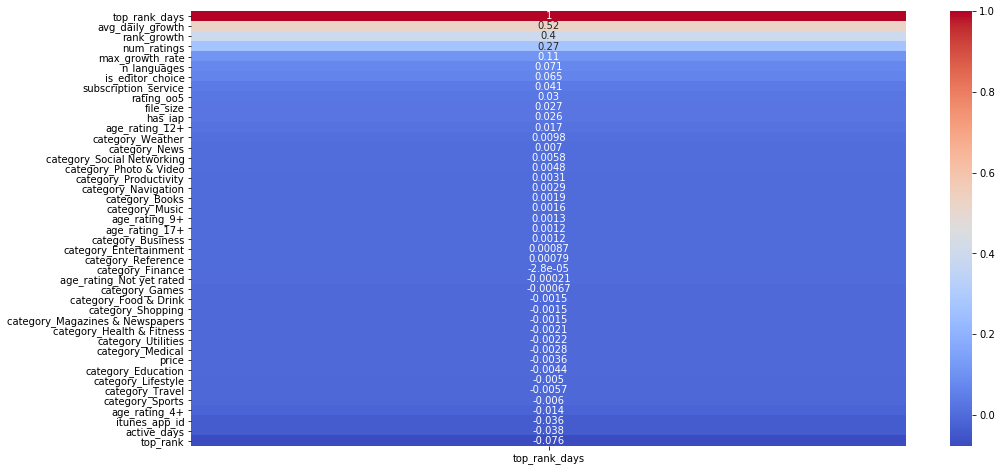

In [0]:
#Features that are highly correlated to top rank days
plt.figure(figsize = (16,8))
focus = final_df.corr()[['top_rank_days']].sort_values(by = 'top_rank_days', ascending = False)
sns.heatmap(focus, cmap ='coolwarm', annot = True);

In [0]:
#Splitting the data into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [0]:
#Scaling the data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [0]:
#The linear regression model
lr = LinearRegression()
lr.fit(X_train_sc, y_train)
cross_val_score(lr, X_test_sc, y_test, cv = 5).mean()

0.36726218171060726

In [0]:
#knearest neighbors
knn = KNeighborsRegressor()
knn.fit(X_train_sc, y_train)
cross_val_score(knn, X_test_sc, y_test, cv = 5).mean()

0.7297524486245319

In [0]:
#Decision tress
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
cross_val_score(dt, X_test, y_test, cv = 5).mean()

0.8892545270127228

In [0]:
#Extra tree regressor
et = ExtraTreeRegressor()
et.fit(X_train, y_train)
cross_val_score(et, X_test, y_test, cv = 5).mean()

0.8137716625196691

In [0]:
#Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
cross_val_score(rf, X_test, y_test, cv = 5).mean()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9148788480364862

In [0]:
# hyperparameters for iteration
grid_params = {
    'n_estimators' : [100,200],
    'min_samples_leaf': [5,7],
}

# Instantiate GridSearch
gs = GridSearchCV(RandomForestRegressor(random_state=42), 
                  param_grid=grid_params, 
                  n_jobs=-1,
                  verbose=1,
                  cv=3)

# Fit Model
gs.fit(X_train, y_train)

# Print the best cross validation score
print(f'The CV score for the best performing model is {gs.best_score_}')

# Print the hyperparameters for the best performing model
print('The hyperparameters for the best performing data is summarized below:')
print(gs.best_params_)

# Print Accruacy for training and testing data from the train/test split
print(f'The Accuracy for the training portion of the training dataset is {gs.score(X_train, y_train)}')
print(f'The Accuracy for the testing portion of the training dataset is {gs.score(X_test, y_test)}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  7.7min finished


The CV score for the best performing model is 0.9278914983334728
The hyperparameters for the best performing data is summarized below:
{'min_samples_leaf': 5, 'n_estimators': 100}
The Accuracy for the training portion of the training dataset is 0.9627589392942949
The Accuracy for the testing portion of the training dataset is 0.9436769958205442


In [0]:
# Instantiate PCA with 34 components.
pca = PCA(n_components = 34)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=34, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
# Instantiate regression model.
rf = RandomForestRegressor()

# Transform Z_train and Z_test.
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

# Fit on Z_train.
rf.fit(Z_train, y_train)

# Score on training and testing sets.
print(f'Training Score: {round(r2_score(y_train, rf.predict(Z_train)),4)}.')
print(f'Testing Score: {round(r2_score(y_test, rf.predict(Z_test)),4)}.')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Score: 0.9843.
Testing Score: 0.9213.
